#  Deutsch-Jozsa Algorithm

The Deustsch-Jozsa algorithm was deviced to distinguish whether a function is constant $f(x)=C$, with $C=0$ or $C=1$, or balanced, meaning that for half of the input values $f(x)=0$ and for the other half $f(x)=1$.

Using a classical computer we need to compute the function at least $2^{n-1}+1$ times, being $n$ the number of bits in $x$, in order to obtain the nature of $f(x)$. The Deustsch-Jozsa algorithm shows that a quantum computer needs to query the function only *once*. To test this, we build an oracle that plays the role of the function $f(x)$ in either case.

This algorithm requires a register of $n$ qubits plus an extra ancillary qubit. The main idea is to exploit the phenomenon of *phase kickback* (see [1]), by which a control qubit is affected when performing a controlled gate on a target qubit.

The first step consists in initializing the first register in the state $H^{n}|00..0\rangle$ and the ancilla in $|- \rangle= H X |0\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$. Next, we perform a CNOT gate on the ancilla, conditioned the oracle, i.e. $|a \rangle \rightarrow | a \oplus f(x) \rangle$, being $|a \rangle$ the state of the ancilla. Finally, we act again with a set of Hadamard gates on the first register and measure these qubits. Mathematically, these steps can be described as

$\begin{align} &|\psi_{0} \rangle = (H^{n}|00..0\rangle)|- \rangle = \frac{1}{2^{n/2}}\sum_{x=0}^{2^{n}-1} |x \rangle|- \rangle \xrightarrow{U_{\textit{oracle}}} |\psi_{1} \rangle = \frac{1}{2^{(n+1)/2}}\sum_{x=0}^{2^{n}-1} |x \rangle(|0 \oplus f(x)\rangle- |1 \oplus f(x) \rangle) = \frac{1}{2^{(n+1)/2}}\sum_{x=0}^{2^{n}-1} (-1)^{f(x)} |x \rangle(|0\rangle- |1 \oplus \rangle)  \\
& \xrightarrow{H^{n}} |\psi_{2} \rangle = \frac{1}{2^{n}} \sum_{x,l} (-1)^{f(x)} (-1)^{x \cdot l} |l \rangle  \end{align}$,

where the sumations are carried over all bit configurations and where $x \cdot l = \sum_{i} x_{i}l_{i} \ (\textrm{mod} \ 2)$. Note that phase kickback manifests as the factor $(-1)^{f(x)}$ in $| \psi_{1} \rangle$.

If $f(x)=C$, regardless of the specific value of $C$, phase kickback contributes only with a global phase to the state. Consequently, after performing the second round of Hadamard gates, all qubits in the first register return to $|00..0 \rangle$, up to a global phase. Therefore, if we measure a finite probability for the qubits to be in $|00..0 \rangle$, we obtain that $f(x)=C$.

If $f(x)$ is balanced, phase kickback will generate relative phases between the qubits. This means that, after the second round of Hadamard gates, the first register ends up in some state orthogonal to $|00..0 \rangle$. If the measurements yield a vanishing probability of being in $|00..0 \rangle$, we obtain instead that $f(x)$ is balanced.

Refs.:

[1] Further details can be found in Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html and https://qiskit.org/textbook/ch-gates/phase-kickback.html

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [2]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import numpy as np
%matplotlib inline 

In [266]:
# Load personal IBM account
IBMQ.load_account() 

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-01-12 13:15:52,840: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Initialization

In [230]:
def initializer(circuit,nqubits):
    
    # Apply a Hadamard gate on each qubit in the circuit
    for qubit in range(nqubits):
        circuit.h(qubit)
    
    return circuit

### Oracle

The oracle is split in two parts, depending on the nature of $f(x)$. 

For $f(x) = C$, if $C=0$, nothing is done on the ancilla, if $C=1$ then we act with an X gate on it. Note this still yields a measurement of the $|00..0 \rangle$ state in the main register. 

For $f(x)$ balanced, we first choose a random binary number (with the same number of digits as in the main register), in order to set which inputs satisfy $f(x)=0$ and $f(x)=1$. This is ensured by acting at the beginning and at the end with X gates on the (random!) qubits assigned with '1' bits. The core part occurs between the first and second round of X gates and corresponds to each qubit in the main register acting with a CNOT gate on the ancilla. This last step corresponds to the action of phase kickback on the main register, leading to a final state orthogonal to $|00..0 \rangle$. In particular, note that starting with $|00..0 \rangle$ as an initial state, for a balanced $f(x)$ the output will be $|11..1 \rangle$.

In [256]:
def oracle(case,nqubits):
    
    oc = QuantumCircuit(nqubits+1)
    
    # Constant case
    if case == 'constant':
        
        # Choose a randomly 0 or 1, to decide whether f(x)=1 or f(x)=0
        num = np.random.randint(2)
        
        # If f(x)=1 flip the ancillary qubit, otherwise don't do anything
        if num == 1:
            oc.x(nqubits)
        
    # Balanced case
    if case == 'balanced':
        
        # We set at random which numbers give f(x)=1 or f(x)=0
        num = np.random.randint(1,2**nqubits)
        # Turn the random number into binary and pad it with zeros
        location = format(num,'0'+str(nqubits)+'b')
        
        # Flip the randomly selected qubits
        for qubit in range(len(location)):
            if location[qubit] == '1':
                oc.x(qubit)
        
        # Apply a CNOT gates on ancillary qubit   
        for qubit in range(nqubits):
            oc.cx(qubit,nqubits)
        
        # Flip the qubits back
        for qubit in range(len(location)):
            if location[qubit] == '1':
                oc.x(qubit)
        
    # Return the oracle as a gate
    oc_gate = oc.to_gate()
    oc_gate.name = "U$_{or}$"
    
    return oc_gate

## Constant function simulation

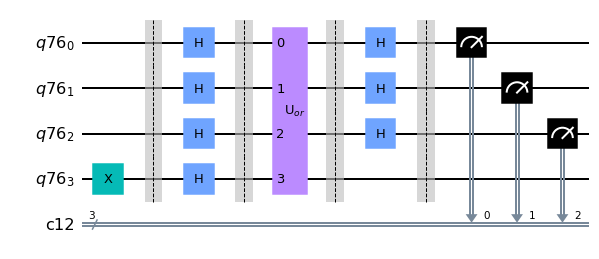

In [257]:
num_qubits = 3 # Number of qubits
function_type = 'constant' # Function type: 'constant'or 'balanced'

qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)


dj_circ = QuantumCircuit(qr,cr)

dj_circ.x(num_qubits) # Set up ancillary qubit in |1> 
dj_circ.barrier()

# Act with Hadamard gates on all qubits
dj_circ = initializer(dj_circ,num_qubits+1) 
dj_circ.barrier()

# Add oracle to the circuit
dj_circ.append(oracle(function_type,num_qubits),qr)
dj_circ.barrier()

# Act again with Hadamard gates on all qubits
dj_circ = initializer(dj_circ,num_qubits)
dj_circ.barrier()

# Measure all qubits in the main register
for qubit in range(num_qubits):
    dj_circ.measure(qubit,qubit)

# Show circuit
dj_circ.draw(output = 'mpl')

### Classical simulation

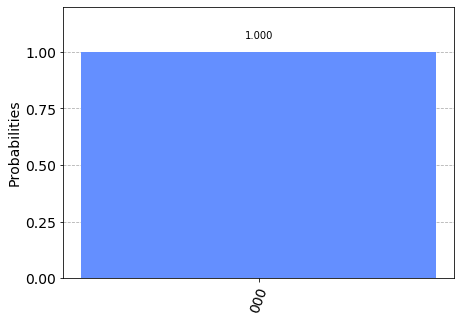

In [258]:
simulator = Aer.get_backend('qasm_simulator')
dj_result = execute(dj_circ, backend = simulator, shots = 1024).result() # Execute the circuit in the backend

plot_histogram(dj_result.get_counts())

As expected from the function being constant, the result is $|00..0 \rangle$.

### Quantum simulation

In [261]:
provider = IBMQ.get_provider(hub='ibm-q')
simQ = provider.get_backend('ibmq_valencia')
dj_circ_job = execute(dj_circ, backend = simQ, shots = 1024)

print(dj_circ_job.job_id())
job_monitor(dj_circ_job)

5ffb577750c62c148a9c9375
Job Status: job has successfully run


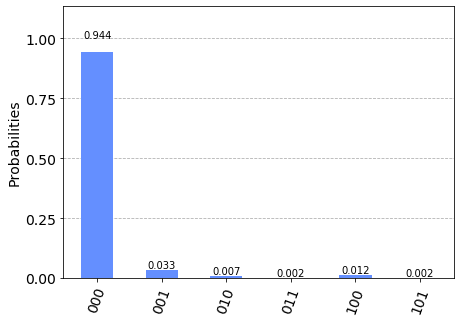

In [262]:
dj_resultQ = dj_circ_job.result()m
plot_histogram(dj_resultQ.get_counts())

Our result matches what we expected with additional errors stemming from imperfections in the real device.

## Balanced function simulation

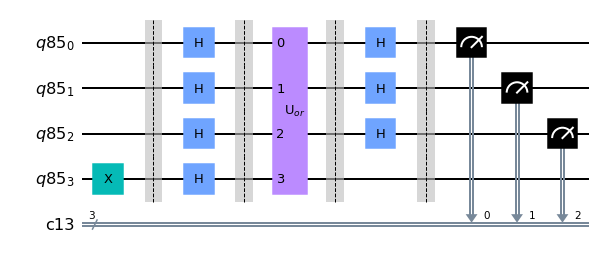

In [264]:
num_qubits = 3 # Number of qubits
function_type = 'balanced' # Function type: 'constant'or 'balanced'

qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)


dj_circ = QuantumCircuit(qr,cr)

dj_circ.x(num_qubits) # Set up ancillary qubit in |1> 
dj_circ.barrier()

# Act with Hadamard gates on all qubits
dj_circ = initializer(dj_circ,num_qubits+1) 
dj_circ.barrier()

# Add oracle to the circuit
dj_circ.append(oracle(function_type,num_qubits),qr)
dj_circ.barrier()

# Act again with Hadamard gates on all qubits
dj_circ = initializer(dj_circ,num_qubits)
dj_circ.barrier()

# Measure all qubits in the main register
for qubit in range(num_qubits):
    dj_circ.measure(qubit,qubit)

# Show circuit
dj_circ.draw(output = 'mpl')

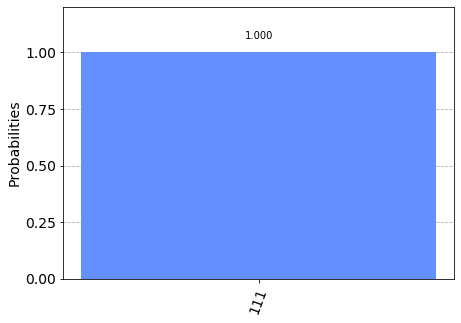

In [250]:
simulator = Aer.get_backend('qasm_simulator')
dj_result = execute(dj_circ, backend = simulator, shots = 1024).result() # Execute the circuit in the backend

plot_histogram(dj_result.get_counts())

As expected from the function being constant, the result is orthogonal to $|00..0 \rangle$.

### Quantum simulation

In [267]:
provider = IBMQ.get_provider(hub='ibm-q')
simQ = provider.get_backend('ibmq_valencia')
dj_circ_job = execute(dj_circ, backend = simQ, shots = 1024)

print(dj_circ_job.job_id())
job_monitor(dj_circ_job)

5ffd9301fd9fc95a8ee5591e
Job Status: job has successfully run


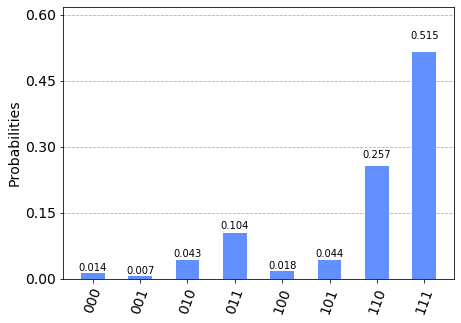

In [268]:
dj_resultQ = dj_circ_job.result()
plot_histogram(dj_resultQ.get_counts())

Our result matches what we expected with additional errors stemming from imperfections in the real device. The reason for these errors to be slightly higher than in the constant case could be sourced by the fact that we act with more gates in this circuit.